/var/folders/sb/bbw9n1955t7gjptn_zsz0z0r0000gn/T/ipykernel_1045/1951744525.py:13: UserWarning: binirizedbaseline.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave('binirizedbaseline.png', binrized)
/var/folders/sb/bbw9n1955t7gjptn_zsz0z0r0000gn/T/ipykernel_1045/1951744525.py:13: UserWarning: binirizedbaseline.png is a low contrast image
  imsave('binirizedbaseline.png', binrized)


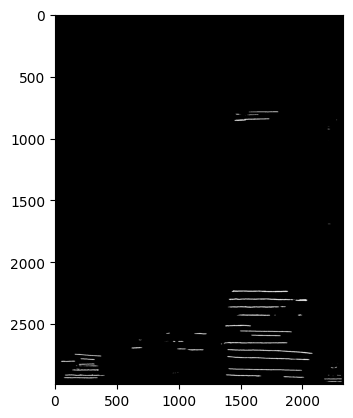

In [263]:
import numpy as np
from scipy.ndimage import binary_erosion, binary_opening
from skimage.io import imread, imsave
from skimage import img_as_float32, img_as_ubyte
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.fftpack import fft

img = img_as_float32(imread('baseline.jpg', as_gray=True))
binrized = img > 0.2

plt.imshow(binrized, cmap='gray')
imsave('binirizedbaseline.png', binrized)


In [106]:
def skeletonize(Bb):
    skeleton = np.zeros_like(Bb, dtype=np.uint8)
    while Bb.max()>0:
        o = binary_opening(Bb)
        skeleton = skeleton | (Bb & 1-o)
        Bb = binary_erosion(Bb)
    return skeleton
Bb = (img > 0.1) * 1
skeleton=skeletonize(Bb)

/var/folders/sb/bbw9n1955t7gjptn_zsz0z0r0000gn/T/ipykernel_1045/1446769986.py:2: UserWarning: skeleton2.png is a low contrast image
  imsave('skeleton2.png', skeleton)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


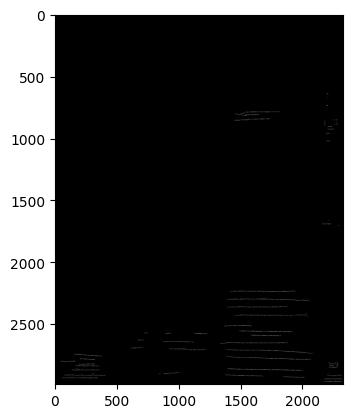

In [7]:
plt.imshow(skeleton, cmap='gray')
imsave('skeleton2.png', skeleton)

/var/folders/sb/bbw9n1955t7gjptn_zsz0z0r0000gn/T/ipykernel_9561/643170933.py:31: UserWarning: superpixels.png is a low contrast image
  imsave('superpixels.png', selected_mask)


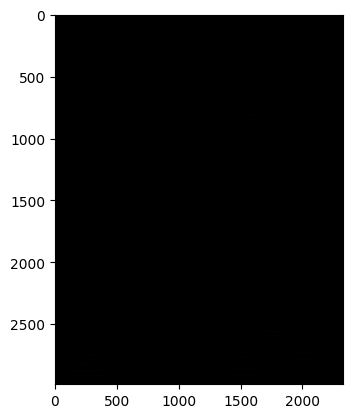

In [4]:
import cv2 
import time
from scipy.sparse import csr_matrix
from skimage import img_as_float

# baseline probs
baselines = np.copy(img)
baselines = img_as_float32(baselines)
sorted_intensity_indexes = np.argsort(baselines.ravel())[::-1]
selected_mask = np.zeros_like(skeleton, dtype=np.uint8)
superpixels = []
for i, index in enumerate(sorted_intensity_indexes):
    # Convert the flattened index to 2D indices
    i, j = np.unravel_index(index, baselines.shape)

    if not skeleton[i,j]:
        continue

    if baselines[i,j] < 0.1:
        break

    # Keeping number of superpixels small
    a = np.array((i,j))
    isValid = (np.array([np.linalg.norm(a-b) for b in superpixels]) >= 10).all()
    if isValid:
        selected_mask[i, j] = 255
        superpixels.append(a)

# print(selected_mask[selected_mask != 0])
plt.imshow(selected_mask, cmap='gray')
imsave('superpixels.png', selected_mask)

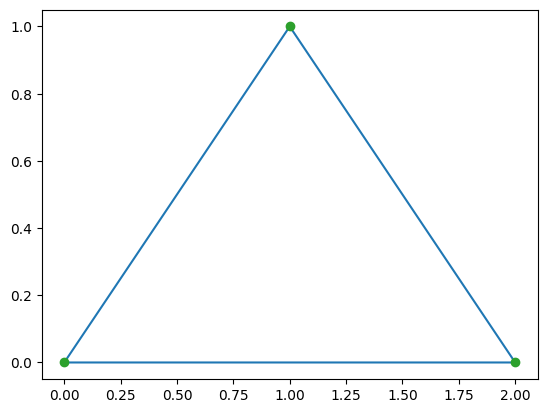

0
[2 1]


In [5]:
from scipy.spatial import Delaunay
from itertools import combinations


# Example set of point coordinates
points = np.array([[0, 0], [1, 1], [2, 0]])


# Compute the Delaunay triangulation
tri = Delaunay(points)

import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

# Example point of interest

point_of_interest = points.tolist().index([0,0])
print(point_of_interest)

def find_neighbors(vertex_id, tri):
        pointer_to_vertex_neighbors, neighbors = tri.vertex_neighbor_vertices
        result_ids = neighbors[pointer_to_vertex_neighbors[vertex_id]:pointer_to_vertex_neighbors[vertex_id + 1]]
        return result_ids

print(find_neighbors(point_of_interest, tri))


In [261]:
def select_superpixels(B, Bs):
    '''
    Filter superpixels in the image.

    Parameters
    ----------
    B : array_like
       Baseline probability image
    Bs : array_like
       Skeletonized baseline image
    '''
    sorted_intensity_indexes = np.argsort(B.ravel())[::-1]
    superpixel_img = np.zeros_like(Bs, dtype=np.uint8)
    superpixels = []
    for index in sorted_intensity_indexes:
        # Convert the flattened index to 2D indices
        i, j = np.unravel_index(index, B.shape)

        if not Bs[i,j]:
            continue

        # If probability is worse than just a guess - pixel should not be part of baseline.
        # Further processing is not needed
        if B[i,j] < 0.2:
            break

        # mapping: i=y, j=x 
        a = np.array([i,j])
        # Keeping number of superpixels small
        isValid = (np.array([np.linalg.norm(a-b) for b in superpixels]) >= 10).all()
        if isValid:
            superpixel_img[i,j] = 255
            superpixels.append(a)
    return superpixels, superpixel_img

In [10]:
def compute_connectivity(e, I):
    '''
    Computes connectivity function - 
    the average intensity of image along the line segment `e`.

    Parameters
    ----------
    e : array_like
        e = (p, q), where p and q are arrays of coordinates of point p and q
    I : array_like
        Input image
    '''
    p, q = e

    segment_vector = np.array(q) - np.array(p)
    # Discretize the integral
    num_points = int(np.linalg.norm(segment_vector))
    intensity_sum = 0
    for t in range(num_points):
        point = np.round(p + t/num_points * segment_vector).astype(int)
        intensity_sum += I[point[0], point[1]]
    return intensity_sum/num_points

def get_point_neighbors(N, p):
    pointList = N.points.tolist()
    if not isinstance(p, list):
        p = list(p)
    p_index = pointList.index(p)
    pointer_to_vertex_neighbors, neighbors = N.vertex_neighbor_vertices
    neighbor_vertices = neighbors[pointer_to_vertex_neighbors[p_index]: \
                                  pointer_to_vertex_neighbors[p_index + 1]]
    nv_coords = [N.points[q] for q in neighbor_vertices]
    return nv_coords

def extract_lto(p, N, B):
    '''
    Extract local text orientation angle for each superpixel

    Parameters
    ----------
    p : list_like
        Superpixel coordinates
    T : object_like
        Delaunay tessellation object
    B : array_like
        The baseline prediction image B
    '''
    nv_coords = get_point_neighbors(N, p)
    M = [(np.array(p), q) for q in nv_coords]
    L = np.array([(e, compute_connectivity(e, B)) for e in M], dtype=object)
    # Sort by baseline connectivities.
    L = L[(-L[:,1]).argsort()]
    # do not consider non-neighbor edges
    max_val = max(L[:,1])
    L = np.array([l for l in L if l[1] > max_val/100])
    if len(L) == 1:
        e = L[0,0]
    else:
        # L[0,0] -> 0th neighbor of p (based on connectivity). Second index denotes
        # edge coordinate position. Next index (1) selects q or r coords that are not p.
        e = (L[0,0][1], L[1,0][1]) 
    return np.arctan(abs(e[1][0] - e[0][0])/(abs(e[1][1] - e[0][1])+ np.finfo(np.float64).eps))


In [519]:
# p = (2875, 1984)
p = (2558, 1523)
extract_lto(p, N, B)

[[(array([2558, 1523]), array([2558., 1533.])) 0.49960787296295167]
 [(array([2558, 1523]), array([2557., 1508.])) 0.49124186038970946]]


0.039978687123290044

In [11]:
def select_points_in_circle(a, points, radius):
    distances = np.linalg.norm(abs(points - a), axis=1)
    mask = distances <= radius
    points_within_circle = points[mask]
    return points_within_circle

def compute_projection_profile(points, angles, diameters):
    points = np.array(points)
    h_pd = []
    for id, p in enumerate(points):
        orientation_vector = np.array([np.cos(angles[id]), np.sin(angles[id])])
        h_d = []
        for dia in diameters:
            ps = select_points_in_circle(p, points, dia/2)
            pq = ps - p
            projections = np.dot(pq, orientation_vector)
            bin_indices = np.round(dia / 2 + projections).astype(int)
            counts = np.bincount(bin_indices, minlength=dia)
            h_d.append(np.array(counts))
        h_pd.append(np.array(h_d))
    return np.array(h_pd)


In [264]:
# Main code
B = img.copy()
Bb = (B > 0.2) * 1
print("running skeleton")
Bs = skeletonize(Bb)
print("running superpixels")
S, SI = select_superpixels(B, Bs)
print(len(S))
print("running delaunay")
N = Delaunay(S)
print("running lto")
angles = [extract_lto(p, N, B) for p in S]
ks = np.array([3,4,5])
ds = np.array([64, 128, 256, 512])
h = compute_projection_profile(S, angles, ds)



running skeleton
running superpixels
745
running delaunay
running lto


/var/folders/sb/bbw9n1955t7gjptn_zsz0z0r0000gn/T/ipykernel_1045/1691584964.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  h_pd.append(np.array(h_d))


7


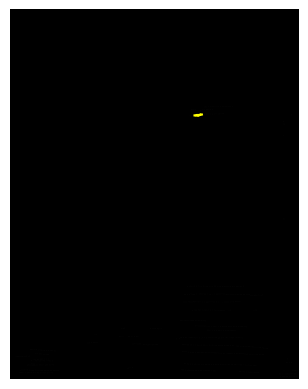

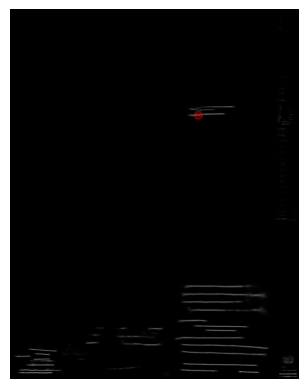

In [280]:
plt.imshow(SI, cmap='gray')
plt.axis("off")
p_idx = 500
x_S = S[p_idx][1]
y_S = S[p_idx][0]
q = select_points_in_circle(S[p_idx], np.array(S), 32)
print(len(q))
for i in range(len(q)):
    y_S2 = q[i][0]
    x_S2 = q[i][1]
    x = [x_S, x_S2]
    y = [y_S, y_S2]
    plt.plot(x,y, c='yellow')
fig, ax = plt.subplots()
ax.imshow(B, cmap='gray')
circle1 = plt.Circle((x_S, y_S), 32, color='r', alpha=.3)
ax.add_patch(circle1)
ax.axis('off')
plt.show()

/var/folders/sb/bbw9n1955t7gjptn_zsz0z0r0000gn/T/ipykernel_1045/1691584964.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  h_pd.append(np.array(h_d))


(745, 4)


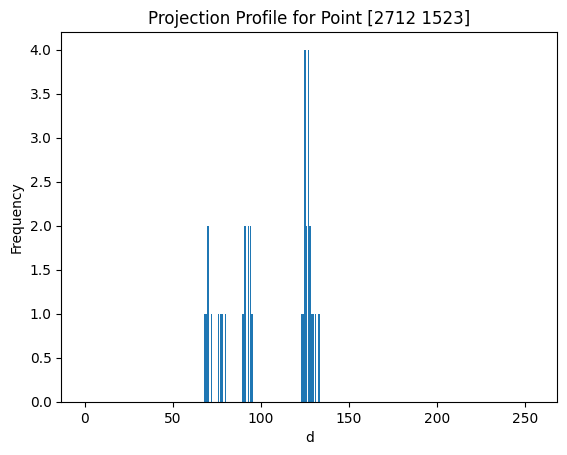

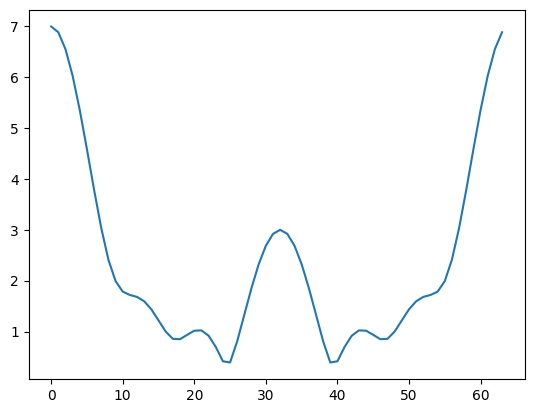

In [283]:
ks = np.array([4,5,6])
ds = np.array([64, 128, 256, 512])
h = compute_projection_profile(S, angles, ds)
print(h.shape)
# fft_arr = fft(np.array(h, dtype=np.int64))
fft_arr = []
for p in range(len(S)):
    fft_d = []
    for d in range(len(ds)):
        fft_d.append(fft(h[p,d]))
    fft_arr.append(fft_d)

plt.bar(range(len(h[500,2])), h[500,2])
plt.xlabel('d')
plt.ylabel('Frequency')
plt.title('Projection Profile for Point {}'.format(S[300]))
plt.show()



H = fft_arr[500][0] #fft(h[300,1])
plt.plot(np.abs(H))
plt.show()


In [267]:
def compute_data_energies(H_pd, S):
    E_s_p = {}
    s_p_set = set()
    for p_id, p in enumerate(S):
        p = tuple(p)
        max_energy = 0
        energy_list = []
        for d_id in range(len(ds)):
            H_pd_dist_sq = np.sum(np.abs(H_pd[p_id][d_id])**2)
            for k_id in range(len(ks)):
                energy = np.abs(H_pd[p_id][d_id][k_id])**2/H_pd_dist_sq
                max_energy = max(energy, max_energy)
                s_p = round(ds[d_id]/ks[k_id])
                s_p_set.add(s_p)
                energy_list.append(energy)
        E_s_p[p] = dict(zip(s_p_set, energy_list))
    S_p_list = sorted(list(s_p_set), reverse=True)
    return S_p_list, E_s_p

# def gen_all_interline_distances(ds, ks):
#     S_d = []
#     for d in ds:
#         for k in ks:
#             S_d.append([d/k, d, k])
#     S_d = -np.sort(-np.array(S_d[:,0]))
#     S_d = S_d.tolist()
#     return S_d

S_p, E_p_s_p = compute_data_energies(fft_arr,S)
print(S_p)
print(E_p_s_p)

def get_max_energy_distance(p, E_pdk):
    p_idx = points.index(p)
    energy_config_map = E_pdk[p_idx]
    highest_energy_idx = np.argmax(energy_config_map.flatten())
    d, k = np.unravel_index(highest_energy_idx, energy_config_map.shape)
    return d/k, E_pdk[d, k]

def data_cost(p, s_p, alpha=1):
    point_dist_energy = E_p_s_p[p][s_p]
    cost =  alpha * (-np.log(point_dist_energy))
    return point_dist_energy

def get_pointlabel_mappings(dists, alpha, beta):
    label2graph = {}
    graph2label = {}
    graph_node = 0
    for p, (_, dist) in dists.items():
        if dist == alpha or dist == beta:
            graph2label[graph_node] = (p, dist)
            label2graph[p] = graph_node
            graph_node += 1
    return graph2label, label2graph

import maxflow as mf

def V_p_q(s_p, s_q, sigma=25):
    '''Definition of the potential'''
    index1 = S_p.index(s_p)
    index2 = S_p.index(s_q)
    dist = abs(index2 - index1)
    return dist if dist < 4 else sigma

def alpha_beta_swap_new(dists, alpha, beta, N):
    graph2label, label2graph = get_pointlabel_mappings(dists, alpha, beta)
    #extract position of alpha or beta interline distances
    graph_mf = mf.Graph[float](len(graph2label))
    nodes = graph_mf.add_nodes(len(graph2label))
    #add n-link edges
    weight = V_p_q(alpha, beta)
    for i in range(len(graph2label)):
        p, _ = graph2label[i]
        nv_nodes = get_point_neighbors(N, p)
        for nv_p in nv_nodes:
            nv_p_key = tuple(nv_p)
            if nv_p_key in label2graph:
                graph_mf.add_edge(i, label2graph[nv_p_key], weight, 0)
   
    #add all the terminal edges
    for i in range(len(graph2label)):
        p, _ = graph2label[i]
        #find neighbours
        nv_nodes = get_point_neighbors(N, p)
        fil_neigh = dict(filter(lambda el: np.any(np.all(np.array(nv_nodes) == el[0], axis=1)) 
                                and el[1][1] != alpha and el[1][1] != beta
                                , dists.items()))
        #consider only neighbours which are not having alpha or beta label
        # fil_neigh = dict(filter(lambda nv: nv[1][1] != alpha and nv[1][1] != beta, nv_dists.items()))
        # print(fil_neigh)
        #calculation of weight
        t_weight_alpha = np.sum([V_p_q(alpha,v[1]) for _,v in fil_neigh.items()]) + data_cost(p, alpha)
        t_weight_beta = np.sum([V_p_q(beta,v[1]) for _,v in fil_neigh.items()]) + data_cost(p, beta)
        graph_mf.add_tedge(nodes[i], t_weight_alpha, t_weight_beta)

    #calculating flow
    graph_mf.maxflow()
    res = [graph_mf.get_segment(nodes[i]) for i in range(len(nodes))]
    # print(res)
    #depending on cut assign new label
    for i in range(len(res)):
        p, _ = graph2label[i] 
        (angle, _) = dists[p]
        if res[i] == 1:
            dists[p] = (angle, alpha)
        else:
            dists[p] = (angle, beta)
    
    return dists

def swap_minimization(dist_states, cycles=1):
    '''This methods implements the energy minimization via alpha-beta-swaps
       img_orig: is original input image
       img_work: optimized image
       cycles: how often to iterate over all labels'''
    T = 0
    import time
    import itertools
    key_combinations = itertools.combinations(S_p, 2)
    unique_pairs = set(key_combinations)
    #do iteration of all pairs a few times
    for u in range(0, cycles):
        #iterate over all pairs of labels 
        for pair in unique_pairs:
            start = np.round(time.time() * 1000)
            dist_states = alpha_beta_swap_new(dist_states, pair[0], pair[1], N)
            print('time', np.round(time.time()*1000) - start)
    return dist_states


[171, 128, 102, 85, 64, 51, 43, 32, 26, 21, 16, 13]
{(2935, 314): {32: 0.084375, 64: 0.026419950274766183, 128: 0.013241630502723837, 102: 0.0744047619047619, 43: 0.038322936293559484, 171: 0.02426344530317455, 13: 0.08551985062893082, 16: 0.030260639682024523, 51: 0.004648604953355909, 21: 0.09003311114958448, 85: 0.048729651114290944, 26: 0.004583278573009397}, (2935, 331): {32: 0.0625, 64: 0.020601178833192568, 128: 0.006906156166325105, 102: 0.06328125, 43: 0.041477288129319126, 171: 0.02393310966635891, 13: 0.07750496031746032, 16: 0.03023553801258754, 51: 0.0036116405172212734, 21: 0.09752926664086688, 85: 0.05293982997616446, 26: 0.005185401594665911}, (2944, 2295): {32: 0.0744485294117647, 64: 0.004674766441456427, 128: 0.013355239310873769, 102: 0.041051136363636366, 43: 0.017301679833908616, 171: 0.0025110508971761415, 13: 0.021814903846153845, 16: 0.009729726409655285, 51: 0.008502761524861582, 21: 0.011403093434343434, 85: 0.008651210536866181, 26: 0.004376191178447745}, (2

In [290]:
states = {tuple(p): (extract_lto(p, N, B), max(E_p_s_p[tuple(p)], key=E_p_s_p[tuple(p)].get)) for p in S}

In [285]:
new_states = swap_minimization(states)
print(len(new_states))
print(new_states)

time 5883.0
time 2581.0
time 0.0
time 1746.0
time 3240.0
time 0.0
time 960.0
time 582.0
time 764.0
time 36.0
time 2648.0
time 35.0
time 3170.0
time 326.0
time 374.0
time 2556.0
time 1640.0
time 1612.0
time 24.0
time 1652.0
time 2466.0
time 168.0
time 3069.0
time 238.0
time 281.0
time 2877.0
time 28.0
time 166.0
time 1.0
time 2820.0
time 34.0
time 167.0
time 2282.0
time 0.0
time 201.0
time 2252.0
time 3138.0
time 75.0
time 3168.0
time 68.0
time 3347.0
time 0.0
time 3341.0
time 0.0
time 0.0
time 68.0
time 3401.0
time 6776.0
time 2921.0
time 0.0
time 2808.0
time 293.0
time 278.0
time 125.0
time 6224.0
time 0.0
time 0.0
time 113.0
time 0.0
time 119.0
time 239.0
time 113.0
time 249.0
time 5996.0
time 0.0
time 0.0
745
{(2935, 314): (0.033320995878247196, 26), (2935, 331): (0.037020115873930025, 26), (2944, 2295): (0.0, 21), (2931, 1994): (0.0, 26), (2935, 202): (0.0, 21), (2936, 301): (0.03844259002118799, 26), (2936, 267): (0.0, 21), (2936, 288): (0.0, 21), (2936, 231): (0.03844259002118799

In [55]:
from scipy import misc
from imageio import imread
def load_img(path, scale, mode):
    aImg = imread(path)
    if scale != 1:
        sImg = np.array(Image.fromarray(aImg).resize())
        fImg = sImg
    else:
        fImg = aImg

    if len(fImg.shape) == 2:
        fImg = np.expand_dims(fImg,2)
    fImg = np.expand_dims(fImg,0)

    return fImg

In [56]:
from skimage import transform
from PIL import Image, ImageDraw
scale = 0.33
orig = Image.open('orig.jpg')
width, height = orig.size
new_size = (int(width * scale), int(height * scale))
resized_img = orig.resize(new_size)
img = ImageDraw.Draw(resized_img)  
for k, (angle_rad, pixels) in new_states.items():
    angle_rad, pixels= new_states[k]
    start_point = (k[0],k[1])
    angle = np.rad2deg(angle_rad) + 90
    angle_rad = np.deg2rad(angle)
    end_point = (int(start_point[0] - np.sin(angle_rad) * int(pixels)), int(start_point[1] + np.cos(angle_rad) * int(pixels)))
    img.line([(k[1], k[0]), (end_point[1], end_point[0]) ], fill ="red", width = 5)
resized_img.show()

In [ ]:
# Old cur solution


def cur(S, deg=3, return_params=False):
    '''
    Computes curvalinearity value. Additionally returns regression curve weights
    '''
    avg_angle = theta(S)
    S_prime = {rotate(k, -avg_angle): v for k, v in S.items()}
    y_prime, x_prime = np.array(list(zip(*S_prime)))
    # print(x_prime)
    # print(y_prime)
    y, x = np.array(list(zip(*S)))
    X = np.array([x_prime**i for i in range(deg+1)]).T
    # Computing the left inverse of X (mxn), since in X we have that m > n:
    # (X^T @ X)^{-1} @ X^T
    x_size = X.shape
    if x_size[0] < x_size[1]:
        X_inv = X.T @ np.linalg.inv(X @ X.T) 
    else:
        X_inv = np.linalg.inv(X.T @ X) @ X.T
    W = X_inv @ y_prime
    y_pred = abs(np.array(X @ W, dtype=int))
    if return_params:
        return np.sqrt(np.mean((y - y_pred)**2))/s(S), W, min(x_prime), max(x_prime)
    else:
        return np.sqrt(np.mean((y - y_pred)**2))/s(S)

[array([1693., 2207.]), array([ 856., 1500.]), array([ 857., 1480.]), array([ 858., 1452.]), array([2236., 1560.]), array([2236., 1488.]), array([2236., 1506.]), array([2236., 1542.]), array([2300., 1507.]), array([2236., 1532.]), array([2300., 1526.])]


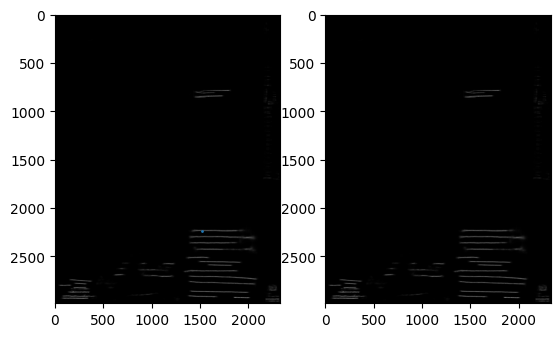

In [550]:
ppoints = get_point_neighbors(N, (2235, 1522))
print(ppoints)
plt.subplot(1,2,1)
plt.imshow(B, cmap='gray')
x = []
y = []
# for p in ppoints:
#     x.append(p[1])
#     y.append(p[0])
# x.append(1994)
x.append(1522)#2875, 1984(2235, 1522)
y.append(2235)
# y.append(2931)
plt.scatter(x, y, s=1)
plt.subplot(1,2,2)
plt.imshow(B, cmap='gray')
plt.show()

In [487]:
e = {}
e[((2931, 1994),(2875, 1984))]= 1
e[((2875, 1984),(2931, 2004))]= 2

a = ((2931, 1994),(2875, 1984))
if a not in e:
    print('t')

In [177]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)
def build_edge_set(N, S, B):
    edge_set = {}
    for p in S.keys():
        neighbors = get_point_neighbors(N, p)
        for nv in neighbors:
            nv = tuple(nv.astype(int))
            # if nv in S:
            isSameOrientied = (np.abs(S[p][0] - S[nv][0]) % np.pi) <= np.pi/4
            isValid = tuple((p, nv)) not in edge_set and tuple((nv, p)) not in edge_set and isSameOrientied
            if isValid:
                q = nv
                e = (p, q)
                union = {p: S[p], q: S[q]}
                angle = theta(union)
                dist1 = compute_off_text_distance(p, q, angle)
                dist2 = L2_norm(p,q)
                factor = 1 - (dist1/dist2)
                edge_set[e] = factor * compute_connectivity(e, B)
    return dict(sorted(edge_set.items(), key=lambda x: x[1], reverse=True))

def rotate(point, angle):
        cos_theta = np.cos(angle)
        sin_theta = np.sin(angle)
        rotation_matrix = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])
        return tuple(np.array(np.dot(rotation_matrix, point), dtype=int))

def cur(S, deg=3, return_params=False):
    '''
    Computes curvalinearity value. Additionally returns regression curve weights
    '''
    avg_angle = theta(S)
    S_prime = {rotate(k, -avg_angle): v for k, v in S.items()}
    y_prime, x_prime = np.array(list(zip(*S_prime)))
    if len(S) == 1 and return_params:
        return 0.0, -1, min(x_prime), max(x_prime)
    elif len(S) == 1:
        return 0.0
    y, x = np.array(list(zip(*S)))
    W = np.polyfit(x_prime, y_prime, 3)
    y_pred = np.poly1d(W)(x)
    if return_params:
        return np.sqrt(np.mean((y - y_pred)**2))/s(S), W, min(x_prime), max(x_prime)
    else:
        return np.sqrt(np.mean((y - y_pred)**2))/s(S)

def compute_off_text_distance(p, q, angle):
    return np.abs((p[1]-q[1])*np.sin(angle) - (p[0]-q[0])*np.cos(angle))

def get_projections(S, print_=False):
    _, W, tmin, tmax = cur(S, return_params=True)

    diff = tmax-tmin
    n = diff if diff > 0 else 1
    t_vals = np.linspace(tmin, tmax, n, dtype=int)
    curve = np.poly1d(W)
    poly = np.array(np.round(curve(t_vals)), dtype=int)
    rotated_points = [rotate((p,t), theta(S)) for p, t in zip(poly, t_vals)]
    angle = theta(S) + np.pi/2
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    projections = []
    for p in S.keys():
        min_dist = np.inf
        projection_idx = 0
        for idx, rp in enumerate(rotated_points):
            dist = np.abs(cos_angle * (p[0] - rp[0]) - sin_angle * (p[1] - rp[1]))
            if dist < min_dist:
                projection_idx = idx
                min_dist = dist
        # print(rotated_points[projection_idx])
        projections.append((rotated_points[projection_idx],S[p]))
    if len(projections) == 1:
        return {projections[0][0]: projections[0][1]}
    projected_states = {}
    for i in range(len(projections)):
        if i == len(projections)-1:
            y0, x0 = projections[i-1][0]
            y1, x1 = projections[i][0]
        else:
            y0, x0 = projections[i][0]
            y1, x1 = projections[i+1][0]
        angle = np.arctan(abs(y1 - y0) / (abs(x1-x0)+np.finfo(float).eps))
        projected_states[projections[i][0]] = (angle, projections[i][1][1])
    if print_:
        print()
        print("S", S)
        print("W", W)
        print("tmin/max", tmin, tmax)
        print("t_vals", t_vals)
        print("poly",poly)
        print("rotatedPoints",rotated_points)
        print("projections",projections)
        print("projected_states",projected_states)
    return projected_states

def L2_norm(p, q):
    return np.sqrt((q[1] - p[1])**2 + (q[0] - p[0])**2)

def cluster_distance(S1, S2):
    # Sc_1 = get_projections(S1) if len(S1) > 1 else S1
    # Sc_2 = get_projections(S2) if len(S2) > 1 else S2
    distances = [np.inf]
    for pk, pv in S1.items():
        for qk, qv in S2.items():
            union = S1.copy()
            union.update(S2)
            if L2_norm(pk, qk) < 4 * s(union):
                point_union = {pk: pv, qk: qv}
                avg_angle = theta(point_union)
                distances.append(compute_off_text_distance(pk, qk, avg_angle))
    # if len(distances) == 1:
    #     distances.append(compute_off_text_distance(pk, qk, avg_angle))
    #     print("Sc_1", Sc_1)
    #     print("Sc_2", Sc_2)
    #     print("S1",S1)
    #     print("S2",S2)
    #     L2 = []
    #     avg_dist= []
    #     for pk, pv in Sc_1.items():
    #         for qk, qv in Sc_2.items():
    #             union = S1.copy()
    #             union.update(S2)
    #             L2.append(L2_norm(pk, qk))
    #             avg_dist.append(4 * s(union))
    #     print("L2", L2)
    #     print("avg_dist", avg_dist)
    return min(distances)


def find_cluster_index(p, P_star):
    '''
    Search for cluster where the point p belongs
    '''
    for i, S_i in enumerate(P_star):
        if p in S_i:
            return i
    return -1

def remove_edge(p, q, N):
    '''
    Removes edge from connectivity sorted edge set
    '''
    if (p,q) in N:
        del N[(p,q)]
    else:
        del N[(q,p)]
    return N

def remove_cfcc(Sx, S0):
    '''
    Remove cluster from clutter cluster
    '''
    for k in Sx:
        if k in S0:
            del S0[k]
    return S0

def remove_cfpl(Sx, P):
    '''
    Remove cluster from partition list
    '''
    return [Si for Si in P if Si != Sx]

def theta(S):
    '''
    Computes average angle
    '''
    return np.mean([v[0] for _,v in S.items()])


def s(S):
    '''
    Computes average interline distance
    '''
    return np.mean([v[1] for _,v in S.items()])


def merge_clusters(p_state, q, i, P_star, S0, N, gamma, delta):
    '''
    Merge point p into cluster Si
    '''
    set_union = P_star[i].copy()
    set_union.update(p_state)

    if cur(set_union) < gamma and cluster_distance(P_star[i], p_state) < delta * s(P_star[i]):
        hasNoInterferingBaselines = [cluster_distance(set_union, P_star[j]) > delta * s(P_star[j]) for j in range(1, len(P_star)) if j != i]
        if all(hasNoInterferingBaselines):
            p = next(iter(p_state))
            N = remove_edge(p, q, N)
            P_star[i] = set_union
            S0 = remove_cfcc(p_state, S0)
    return S0, N, P_star
     
import time
def cluster_sp(N, states, delta = 0.5, gamma = 0.3):
    S0 = states.copy()
    P_star = [S0]
    n = 0
    N = build_edge_set(N, S0, B)  
    print(N)
    while len(N) != n:
        n = len(N)
        keys = N.copy().keys()
        for (p, q) in keys:
            # print("keys",p,q)
            p_state = {p: states[p]}
            q_state = {q: states[q]}
            p_idx = find_cluster_index(p, P_star)
            q_idx = find_cluster_index(q, P_star)
            if p_idx > 0 and p_idx == q_idx:
                # Already in some cluster
                N = remove_edge(p, q, N)
                # print(len(N))
                # print("already inplace", np.round(time.time()*1000-start))
            elif p_idx == 0 and q_idx == 0:
                # Create a new cluster
                avg_angle = np.average([p_state[tuple(p)][0], q_state[tuple(q)][0]])
                union_state = p_state.copy()
                union_state.update(q_state)
                if compute_off_text_distance(p, q, avg_angle) < delta * s(union_state):
                    N = remove_edge(p, q, N)
                    Snew = union_state
                    S0 = remove_cfcc(Snew, S0)
                    P_star.append(Snew)
                    # print(len(N))
                # print("new cluster", np.round(time.time()*1000-start))
            elif p_idx == 0 and q_idx > 0:
                # Attempt to merge point p from clutter cluster into cluster with point q
                S0, N, P_star = merge_clusters(p_state, q, q_idx, P_star, S0, N, gamma, delta)
                # print(len(N))
                # print("merge cluster", np.round(time.time()*1000-start))
            elif q_idx == 0 and p_idx > 0:
                # Attempt to merge point q from clutter cluster into cluster with point p
                S0, N, P_star = merge_clusters(q_state, p, p_idx, P_star, S0, N, gamma, delta)
                # print(len(N))
                # print("merge cluster", np.round(time.time()*1000-start))
            elif p_idx != q_idx and (p_idx > 0 and q_idx > 0):
                # Attempt to merge p and q neighboring clusters
                Si = P_star[p_idx].copy()
                Sj = P_star[q_idx].copy()
                union_set = Si.copy()
                union_set.update(Sj)
                validMerge = cur(union_set) < gamma \
                        and cluster_distance(Si, Sj) < delta * min(s(Si), s(Sj))
                if validMerge:
                    N = remove_edge(p, q, N)
                    P_star[p_idx] = union_set
                    P_star = remove_cfpl(Sj, P_star)
                    # print(len(N))
                # print("merge 2 clusters", np.round(time.time()*1000-start))
    return P_star

In [457]:
P_star_Test = cluster_sp(N, new_states) 

{((2935, 314), (2935, 331)): 0.8119318455103091, ((2931, 1994), (2931, 1984)): 0.8023530066013336, ((2935, 314), (2936, 341)): 0.7743123799282916, ((2936, 301), (2936, 288)): 0.7716060888228021, ((2936, 288), (2936, 278)): 0.7666667222976684, ((2936, 267), (2936, 278)): 0.766131959178231, ((2936, 267), (2936, 257)): 0.7603922069072724, ((2945, 2249), (2945, 2239)): 0.757254958152771, ((2935, 202), (2935, 189)): 0.7565670538694991, ((2936, 231), (2936, 247)): 0.7507293693029328, ((2935, 202), (2935, 221)): 0.7458476600117905, ((2945, 2249), (2945, 2259)): 0.743529450893402, ((2944, 2295), (2944, 2281)): 0.7419279133633612, ((2936, 247), (2936, 257)): 0.7368627667427063, ((2935, 202), (2936, 231)): 0.7368001957337389, ((2936, 231), (2935, 189)): 0.7330909272199145, ((2935, 314), (2936, 301)): 0.7290777211070775, ((2936, 301), (2936, 341)): 0.7189222065871959, ((2935, 172), (2935, 160)): 0.7147059043248495, ((2927, 1851), (2928, 1871)): 0.7140290758137714, ((2935, 331), (2936, 341)): 0.71

In [52]:
key1 = (2935, 314)
key2 = (2935, 331)
key3 = (2936, 301)
key4 = (2936, 288)
key5 = (2935, 202)
S1 = {key1: new_states[key1], key2: new_states[key2], key5: new_states[key5], key3: new_states[key3], key4: new_states[key4]} 
# S2 = {key3: new_states[key3], key4: new_states[key4]}
# val, W, tmin, tmax = cur(S1,return_params=True)
# a,b,c,d = W
# def curve(x):
#     return a*x**3 + b*x**2 + c*x + d
# print(curve(133))
# print(val)
# print(tmin)
# print(tmax)


# cluster_distance(S1, S2)
# print(S1)
# Sc_1 = get_projections(S1, print_=True)
# print(Sc_1)
# cluster_distance(S1, S2)
# print(S[:50])

# N_test = Delaunay(S[:500])
# test_state = {}
# for i, e in enumerate(new_states.items()):
#     if i == 500:
#         break
#     test_state.update({e[0]:e[1]})
# print(N)
P_star = cluster_sp(N, new_states) 


{((2935, 314), (2935, 331)): 0.8119318455103091, ((2931, 1994), (2931, 1984)): 0.8023530066013336, ((2935, 314), (2936, 341)): 0.7743123799282916, ((2936, 301), (2936, 288)): 0.7716060888228021, ((2936, 288), (2936, 278)): 0.7666667222976684, ((2936, 267), (2936, 278)): 0.766131959178231, ((2936, 267), (2936, 257)): 0.7603922069072724, ((2945, 2249), (2945, 2239)): 0.757254958152771, ((2935, 202), (2935, 189)): 0.7565670538694991, ((2936, 231), (2936, 247)): 0.7507293693029328, ((2935, 202), (2935, 221)): 0.7458476600117905, ((2945, 2249), (2945, 2259)): 0.743529450893402, ((2944, 2295), (2944, 2281)): 0.7419279133633612, ((2936, 247), (2936, 257)): 0.7368627667427063, ((2935, 202), (2936, 231)): 0.7368001957337389, ((2936, 231), (2935, 189)): 0.7330909272199145, ((2935, 314), (2936, 301)): 0.7290777211070775, ((2936, 301), (2936, 341)): 0.7189222065871959, ((2935, 172), (2935, 160)): 0.7147059043248495, ((2927, 1851), (2928, 1871)): 0.7140290758137714, ((2935, 331), (2936, 341)): 0.71

In [53]:
from PIL import Image, ImageDraw

image = Image.fromarray(B)
image = image.convert("L")
# Create a drawing object
draw = ImageDraw.Draw(image)

# Define the line color and width
line_color = (255, 0, 0)  # red
line_width = 1

# Define the start and end points of the line
start_point = (0, 0)
end_point = (image.width, image.height)
for i in range(1, len(P_star)):
    ps = P_star[i]
    epoints = []
    for p in list(ps.keys()):
        epoints.append((p[1],p[0]))
        # y.append(p[0])
# Draw the line on the image
    draw.line(epoints, fill=255, width=10)
print(epoints[0])
# plt.imshow(image, cmap='gray')

# Save the modified image
image.save("image.png")

(2207, 1693)


{(2927, 1861): (0.049958395721942765, 26), (2945, 2271): (0.04542327942157701, 26), (2935, 221): (0.034469100999508014, 21), (2936, 257): (0.0, 21), (2927, 1881): (0.04164257909858842, 26), (2935, 122): (0.027770636593421036, 26), (2935, 150): (0.049958395721942765, 26), (846, 1662): (0.0, 16), (2824, 265): (0.04164257909858842, 21), (2825, 232): (0.039978687123290044, 21), (2874, 1973): (0.04542327942157701, 26), (2874, 1937): (0.04345089539153084, 26), (2562, 1845): (0.037020115873930025, 26), (2562, 1801): (0.0, 26), (2870, 1762): (0.0, 26), (2914, 1439): (0.049958395721942765, 26), (2936, 341): (0.07677189126977804, 26), (2912, 116): (0.04542327942157701, 26), (2865, 186): (0.09966865249116204, 21), (2865, 1441): (0.037020115873930025, 26), (2914, 158): (0.0964737751825869, 21), (2824, 309): (0.41822432957922906, 21), (2916, 1469): (0.049958395721942765, 26), (2870, 1820): (0.0, 26), (2873, 284): (0.0, 21), (2563, 1877): (0.047583103276983396, 26), (2866, 1486): (0.0, 21), (2749, 2

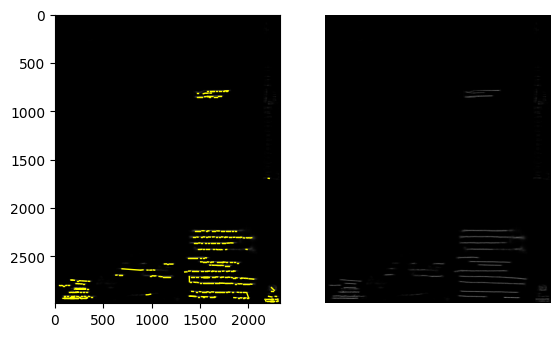

In [586]:
print(P_star[0])

plt.subplot(1,2,1)
plt.imshow(B, cmap='gray')
# plt.axis("off")

x = []
y=[]
for i in range(1, len(P_star)):
    ps = P_star[i]
    print(list(ps.keys()))
    x = []
    y=[]
    for p in list(ps.keys()):
        x.append(p[1])
        y.append(p[0])
    # y = list(P_star[0].keys())[:,0]
    # print(len(q))
    # for i in range(len(q)):
    #     y_S2 = q[i][0]
    #     x_S2 = q[i][1]
    #     x = [x_S, x_S2]
    #     y = [y_S, y_S2]
    plt.plot(x,y, c='yellow',linewidth=1)
plt.subplot(1,2,2)
plt.imshow(B, cmap='gray')
plt.axis('off')

plt.show()

In [286]:
# All the info I need to compute the clusters of SPs
# print(states)
# print(skeleton[skeleton!=0])
# print(N)
def L2_norm(p, q):
    return np.sqrt((q[1] - p[1])**2 + (q[0] - p[0])**2)

def get_skeleton_pixels(p, q):
    y0, x0 = p
    y1, x1 = q
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = -1 if x0 > x1 else 1
    sy = -1 if y0 > y1 else 1
    err = dx - dy
    pixels = []
    while x0 != x1 or y0 != y1:
        if skeleton[y0,x0]:
            pixels.append((x0, y0))
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    if skeleton[y1,x1]:
        pixels.append((x1, y1))
    return len(pixels)

def compute_connectivity1(e, I):
    p, q = e

    segment_vector = np.array(q) - np.array(p)
    # Discretize the integral
    num_points = int(np.linalg.norm(segment_vector))
    intensity_sum = 0
    for t in range(num_points):
        point = np.round(p + t/num_points * segment_vector).astype(int)
        intensity_sum += I[point[0], point[1]]
        
    return intensity_sum/num_points

def build_edge_set(N, S, B):
    edge_set = {}
    for p in S.keys():
        neighbors = get_point_neighbors(N, p)
        for nv in neighbors:
            nv = tuple(nv.astype(int))
            # if nv in S:
            isSameOrientied = (np.abs(S[p][0] - S[nv][0]) % np.pi) <= np.pi/4
            isValid = tuple((p, nv)) not in edge_set and tuple((nv, p)) not in edge_set and isSameOrientied
            if isValid:
                q = nv
                e = (p, q)
                union = {p: S[p], q: S[q]}
                angle = theta(union)
                dist1 = compute_off_text_distance(p, q, angle)
                dist2 = L2_norm(p,q)
                factor = 1 - (dist1/dist2)
                edge_set[e] = factor * compute_connectivity(e, B)
    return dict(sorted(edge_set.items(), key=lambda x: x[1], reverse=True))

def small_distance(S1, S2):
    for pk in S1.keys():
        for qk in S2.keys():
            if L2_norm(pk, qk) <= 20:
                return True

S0 = states.copy()
# sorted_states = states.copy()
# sorted_states = dict(sorted(sorted_states.items(), key=lambda x: x[0][1]))

# edges = build_edge_set(N, S0, skeleton)
P_star = [S0] 
unconnected_ps = []
for p in states:
    NVs = get_point_neighbors(N, p)
    nv_connectivity = []
    p_state = {p: states[p]}
    for nv in NVs:
        q = tuple(nv.astype(int))
        isSameOriented = (abs(states[p][0] - states[q][0]) % np.pi) <= np.pi/4
        interpdist = L2_norm(p, q)
        # if not following the skeleton - skip
        if isSameOriented and interpdist <= 20:
            nv_connectivity.append([q, compute_connectivity1((p,q), skeleton)])
    if len(nv_connectivity) == 0:
        unconnected_ps.append(p)
        continue
    strongest_NVs = np.array(nv_connectivity)
    strongest_NVs[::-1,1].sort()
    if len(strongest_NVs) > 1 and strongest_NVs[1,1]/(strongest_NVs[0,1]+np.finfo(float).eps) > 0.3:
        strongest_NVs = strongest_NVs[0:2, 0]
    else:
        strongest_NVs = [strongest_NVs[0, 0]]

    for q in strongest_NVs:
        p_idx = find_cluster_index(p, P_star)
        q_idx = find_cluster_index(q, P_star)
        q_state = {q: states[q]}

        if p_idx == 0 and q_idx == 0:
            # Create a new cluster
            union_state = p_state.copy()
            union_state.update(q_state)
            Snew = union_state
            S0 = remove_cfcc(Snew, S0)
            P_star.append(Snew)
        elif p_idx == 0 and q_idx > 0:
            # Merge p to a cluster
            set_union = P_star[q_idx].copy()
            set_union.update(p_state)
            P_star[q_idx] = set_union
            S0 = remove_cfcc(p_state, S0)
        elif q_idx == 0 and p_idx > 0:
            # Merge q to a cluster
            set_union = P_star[p_idx].copy()
            set_union.update(q_state)
            P_star[p_idx] = set_union
            S0 = remove_cfcc(q_state, S0)
        elif p_idx != q_idx and (p_idx > 0 and q_idx > 0):
            # Attempt to merge p and q neighboring clusters
            Si = P_star[p_idx].copy()
            Sj = P_star[q_idx].copy()
            union_set = Si.copy()
            union_set.update(Sj)
            P_star[p_idx] = union_set
            P_star = remove_cfpl(Sj, P_star)
        # Otherwise - ignore since both points are in the same cluster

# Fix connectivity mistakes in skeleton - if distance between segements is no larger than the discretization upperlimit - the clusters should be merged. Otherwise it is a mistake of ARU-Net
n = len(P_star)
i = 1
while i < n:
    j=i+1
    wasMerged = False
    while j < n:
        if small_distance(P_star[i], P_star[j]):
            P_star[i] |= P_star[j]
            del P_star[j]
            n -= 1
            wasMerged = True
        else:
            j += 1
    if not wasMerged:
        i += 1
P_star = [set_i for set_i in P_star if len(set_i) >= 5]
print(len(P_star))





/var/folders/sb/bbw9n1955t7gjptn_zsz0z0r0000gn/T/ipykernel_1045/1467578173.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  strongest_NVs = np.array(nv_connectivity)


29


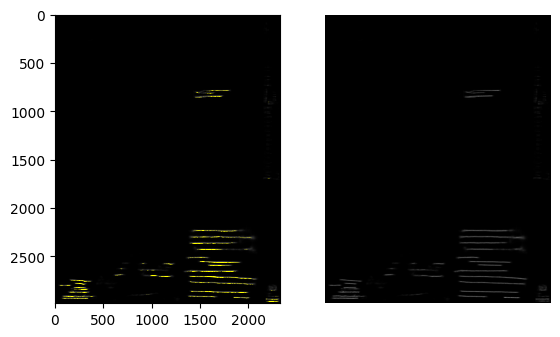

In [161]:
# print(P_star[0])

plt.subplot(1,2,1)
plt.imshow(B, cmap='gray')
# plt.axis("off")

x = []
y=[]
for i in range(1, len(P_star)):
    ps = P_star[i]
    # print(list(ps.keys()))
    x = []
    y=[]
    for p in list(ps.keys()):
        x.append(p[1])
        y.append(p[0])
    # y = list(P_star[0].keys())[:,0]
    # print(len(q))
    # for i in range(len(q)):
    #     y_S2 = q[i][0]
    #     x_S2 = q[i][1]
    #     x = [x_S, x_S2]
    #     y = [y_S, y_S2]
    plt.plot(x,y, c='yellow',linewidth=0.1)
plt.subplot(1,2,2)
plt.imshow(B, cmap='gray')
plt.axis('off')

plt.show()

In [287]:
from PIL import Image, ImageDraw

image = Image.fromarray(SI)
image = image.convert("RGBA")
# Create a drawing object
draw = ImageDraw.Draw(image)



# epoints = []
# line_color = (124,252,0)  # green
# nonzero_indices = np.nonzero(skeleton)
# skeleton_points = list(zip(nonzero_indices[0], nonzero_indices[1])) 
# for sp in skeleton_points:
#     epoints.append((sp[1],sp[0]))
# draw.line(epoints, fill=line_color, width=1)

# Define the line color and width
line_color = (255, 255, 0)  # red
line_width = 1
import random
for i in range(1, len(P_star)):
    # if len(P_star[i]) < 5:
    #     continue
    ps = P_star[i]
    epoints = []
    for p in list(ps.keys()):
        epoints.append((p[1],p[0]))
        # y.append(p[0])
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    
# Draw the line on the image
    draw.line(epoints, fill=(r, g, b), width=1)
# plt.imshow(image, cmap='gray')

# Save the modified image
image.save("image.png")

In [295]:
from skimage import transform
from PIL import Image, ImageDraw
from scipy.spatial import ConvexHull

scale = 0.33
orig = Image.open('orig.jpg')
width, height = orig.size
new_size = (int(width * scale), int(height * scale))
resized_img = orig.resize(new_size)
img = ImageDraw.Draw(resized_img)  
for i in range(1, len(P_star)):
    Si = P_star[i]
    polygon_set = []
    sum_of_dists = 0
    for k, v in Si.items():
        sum_of_dists += states[k][1]
    mean_dist = sum_of_dists/len(Si)
    for p in Si:
        (angle_rad, pixels) = new_states[p]
        start_point = (p[1],p[0])
        polygon_set.append(start_point)
        angle = np.rad2deg(angle_rad) + 90
        angle_rad = np.deg2rad(angle)
        end_point = (int(p[1] + np.cos(angle_rad) * int(pixels+10)), int(p[0] - np.sin(angle_rad) * int(pixels+10)))
        polygon_set.append(end_point)
        # img.line([(k[1], k[0]), (end_point[1], end_point[0]) ], fill ="red", width = 5)
    hull = ConvexHull(polygon_set)
    sorted_points = [tuple(polygon_set[i]) for i in hull.vertices]
    img.polygon(sorted_points, outline="red",  width = 1)
resized_img.show()

In [293]:
print(states)

{(2935, 314): (0.033320995878247196, 21), (2935, 331): (0.037020115873930025, 21), (2944, 2295): (0.0, 32), (2931, 1994): (0.0, 21), (2935, 202): (0.0, 32), (2936, 301): (0.03844259002118799, 21), (2936, 267): (0.0, 13), (2936, 288): (0.0, 32), (2936, 231): (0.03844259002118799, 32), (2936, 247): (0.0, 13), (2927, 1861): (0.049958395721942765, 21), (2945, 2249): (0.0, 32), (2945, 2271): (0.04542327942157701, 102), (2935, 221): (0.034469100999508014, 32), (2936, 278): (0.0, 13), (2874, 180): (0.047583103276983396, 13), (2935, 104): (0.0, 32), (2935, 172): (0.0, 13), (2930, 1930): (0.047583103276983396, 21), (2935, 189): (0.034469100999508014, 21), (2945, 2239): (0.0, 32), (2929, 1895): (0.07677189126977804, 21), (2945, 2184): (0.034469100999508014, 32), (2936, 257): (0.0, 13), (2935, 94): (0.027770636593421036, 21), (2944, 2281): (0.04164257909858842, 32), (2935, 160): (0.0, 32), (2839, 307): (0.0, 13), (846, 1689): (0.04345089539153084, 13), (2945, 2259): (0.0, 32), (846, 1701): (0.045

In [803]:
from scipy.ndimage import grey_dilation
from scipy import ndimage
from skimage.color import rgb2gray
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops, find_contours
from scipy.ndimage import binary_fill_holes
from skimage.filters import threshold_otsu

def convex_hull_polygon(polygon_set):
    hull = ConvexHull(polygon_set)
    return np.array([polygon_set[i] for i in hull.vertices])

def separate_lines(label):
    label = rgb2gray(label)
    thresh = threshold_otsu(label)
    label = label < 0.5
    dilated = grey_dilation(label, footprint=np.ones((15, 15)))
    dist_transform = ndimage.distance_transform_edt(dilated)
    peak_idx = peak_local_max(dist_transform, footprint=np.ones((51, 51)), labels=dilated)
    local_maxi = np.zeros_like(dist_transform, dtype=bool)
    local_maxi[tuple(peak_idx.T)] = True
    markers, _ = ndimage.label(local_maxi)
    return dilated, dist_transform, watershed(-dist_transform, markers, mask=dilated)

def get_line_bbox(Si):
    polygon_set = []
    sum_of_dists = 0
    for _, v in Si.items():
        sum_of_dists += v[1]
    mean_dist = sum_of_dists/len(Si)
    for p in Si:
        angle_rad = states[p][0]
        polygon_set.append(p)
        angle = np.rad2deg(angle_rad) + 90
        angle_rad = np.deg2rad(angle)
        end_point = (int(p[0] - np.sin(angle_rad) * int(mean_dist)), int(p[1] + np.cos(angle_rad) * int(mean_dist)))
        polygon_set.append(end_point)
    sorted_points = convex_hull_polygon(polygon_set)
    minx = min(sorted_points[:,1])-25
    maxx = max(sorted_points[:,1])+25
    miny = min(sorted_points[:,0])-25
    maxy = max(sorted_points[:,0])+25
    return minx, miny, maxx, maxy

# Merge computed segments that are closest to baseline
def merge_line_segments(img, baseline, watershed_segments):
    segments_to_merge = []
    for p in baseline:
        min_dist = np.inf
        conv_hull = []
        for region in regionprops(watershed_segments):
            minr, minc, maxr, maxc = region.bbox
            closest_x = max(minc, min(p[1], maxc))
            closest_y = max(minr, min(p[0], maxr))
            closest_point = [closest_x, closest_y]
            distance = np.sqrt((p[1] - closest_point[0]) ** 2 + (p[0] - closest_point[1]) ** 2)
            if distance < min_dist:
                min_dist = distance
                conv_hull = [region.bbox, region.image_convex]
        segments_to_merge.append(conv_hull)

    binary_image = np.zeros_like(img, dtype=bool)
    polygon_points = np.array([], dtype=np.int64).reshape(0,2)
    for bbox, conv in segments_to_merge:
        minr, minc, maxr, maxc = bbox
        binary_image[minr:maxr, minc:maxc] += conv
        polygon_points = np.vstack([polygon_points, [[minr, minc], [minr, maxc], [maxr, maxc], [maxr,minc]]])
    sorted_points = convex_hull_polygon(polygon_points)
    return binary_image, sorted_points

def remove_outliers(img, dilated, sorted_points):
    # Remove non line segments
    other_classes = dilated.copy()
    other_classes[img] = False

    mask = np.zeros_like(img, dtype=bool)
    mask_img = Image.fromarray(mask)
    draw = ImageDraw.Draw(mask_img)
    points= [(s[1], s[0]) for s in sorted_points]
    draw.polygon(points, outline=True, width =1)
    mask_array = np.array(mask_img)
    filled_image = binary_fill_holes(mask_array)
    filled_image[filled_image == other_classes] = False
    return filled_image

def trace_contour(filtered_shape):
    # Find the contour on updated shape
    contours = find_contours(filtered_shape)
    if len(contours) > 1:
        sorted_contours = np.array(sorted(contours, key=len, reverse=True))
        bounding_contour = sorted_contours[0]
    else:
        bounding_contour = np.array(contours)[0]
    return bounding_contour



In [764]:
scale = 0.33
orig = Image.open('orig.jpg')
width, height = orig.size
new_size = (int(width * scale), int(height * scale))
resized_img = orig.resize(new_size)
img = np.array(resized_img)
segmentations = []
for i in range(1, len(P_star)):
    Si = P_star[i]
    minx, miny, maxx, maxy = get_line_bbox(Si)
    new_baseline = np.array(list(Si.keys()))
    new_baseline[:,1] -= minx 
    new_baseline[:,0] -= miny 
    label = img[miny:maxy, minx:maxx]/255
    dilated, dist_transform, watershed_segments = separate_lines(label)
    binary_image, polygon_points = merge_line_segments(dilated, new_baseline, watershed_segments)
    filtered_shape = remove_outliers(binary_image, dilated, polygon_points)
    contour = trace_contour(filtered_shape)
    full_size_contour = contour.copy()
    full_size_contour[:,1] += minx 
    full_size_contour[:,0] += miny 
    segmentations.append(full_size_contour.astype(int))

draw = ImageDraw.Draw(resized_img)

for seg in segmentations:
    points= [(s[1], s[0]) for s in seg]
    draw.polygon(points, outline=(255,0,0), width =1)
resized_img.show()

/var/folders/sb/bbw9n1955t7gjptn_zsz0z0r0000gn/T/ipykernel_1045/1686538784.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sorted_contours = np.array(sorted(contours, key=len, reverse=True))


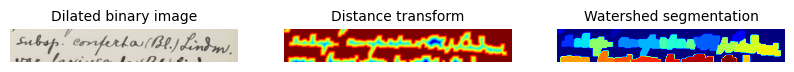

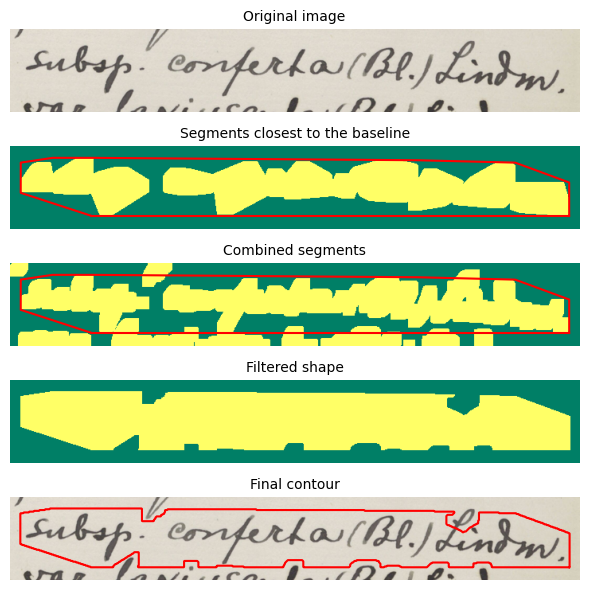

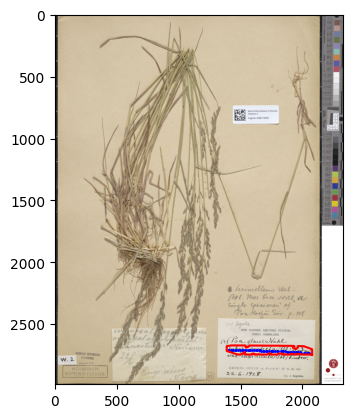

In [805]:
# This assumes only single line is given to process
# For document illustration purposes 
font_size = 10
scale = 0.33
orig = Image.open('orig.jpg')
width, height = orig.size
new_size = (int(width * scale), int(height * scale))
resized_img = orig.resize(new_size)
img = np.array(resized_img)
Si = P_star[16]
minx, miny, maxx, maxy = get_line_bbox(Si)
new_baseline = np.array(list(Si.keys()))
new_baseline[:,1] -= minx 
new_baseline[:,0] -= miny 
label = img[miny:maxy, minx:maxx]/255

# Find segment split points
dilated, dist_transform, watershed_segments = separate_lines(label)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
axes[0].imshow(label, cmap='gray')
axes[0].set_title('Dilated binary image', fontsize = font_size)
axes[0].axis('off')
axes[1].imshow(-dist_transform, cmap='jet')
axes[1].set_title('Distance transform', fontsize = font_size)
axes[1].axis('off')
axes[2].imshow(watershed_segments, cmap='jet')
axes[2].set_title('Watershed segmentation', fontsize = font_size)
axes[2].axis('off')
plt.savefig("watershed_segment.png")
plt.show()


# Merge segments near baseline
binary_image, polygon_points = merge_line_segments(dilated, new_baseline, watershed_segments)
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(25, 6))
axes[0].set_title('Original image', fontsize = font_size)
axes[0].imshow(img[miny:maxy, minx:maxx]/255, cmap='gray')
axes[0].axis('off')

axes[1].set_title('Segments closest to the baseline', fontsize = font_size)
axes[1].imshow(binary_image, cmap='summer')
axes[1].plot(polygon_points[:,1],polygon_points[:,0], c='red')
axes[1].plot([polygon_points[0,1], polygon_points[-1,1]], [polygon_points[0,0], polygon_points[-1,0]], c='red')
axes[1].axis('off')

axes[2].set_title('Combined segments', fontsize = font_size)
axes[2].imshow(dilated, cmap='summer')
axes[2].plot(polygon_points[:,1],polygon_points[:,0], c='red')
axes[2].plot([polygon_points[0,1], polygon_points[-1,1]], [polygon_points[0,0], polygon_points[-1,0]], c='red')
axes[2].axis('off')


# Remove other segments
filtered_shape = remove_outliers(binary_image, dilated, polygon_points)
axes[3].set_title('Filtered shape', fontsize = font_size)
axes[3].imshow(filtered_shape, cmap='summer')
axes[3].axis('off')


# Get final contour
contour = trace_contour(filtered_shape)
axes[4].set_title('Final contour', fontsize = font_size)
axes[4].imshow(label, cmap='gray')
axes[4].plot(contour[:,1],contour[:,0], c='red')
axes[4].axis('off')
plt.tight_layout()
plt.savefig("line_segment_example.png")
plt.show()

full_size_contour = contour.copy()
full_size_contour[:,1] += minx 
full_size_contour[:,0] += miny 

plt.imshow(resized_img)
plt.plot(full_size_contour[:,1],full_size_contour[:,0], c='red')
ps = np.array(list(Si.keys()))
plt.scatter(ps[:,1], ps[:,0], c='blue', s=1)
plt.show()